In [14]:
from slam import fast_slam
from slam.fast_slam import Particle
from utils.rover import Rover, Pose
from control import pose_control
import numpy as np
import matplotlib.pyplot as plt
import math
from ipywidgets import interact

FastSLAM algorithm implementation is based on particle filters and belongs to the family of probabilistic SLAM approaches. It is used with feature-based maps (see gif above) or with occupancy grid maps.

As it is shown, the particle filter differs from EKF by representing the robot's estimation through a set of particles. Each single particle has an independent belief, as it holds the pose $(x, y, \theta)$ and an array of landmark locations $[(x_1, y_1), (x_2, y_2), ... (x_n, y_n)]$ for n landmarks.

- The blue line is the true trajectory
- The red line is the estimated trajectory
- The red dots represent the distribution of particles
- The black line represent dead reckoning tracjectory
- The blue x is the observed and estimated landmarks
- The black x is the true landmark

I.e. Each particle maintains a deterministic pose and n-EKFs for each landmark and update it with each measurement.

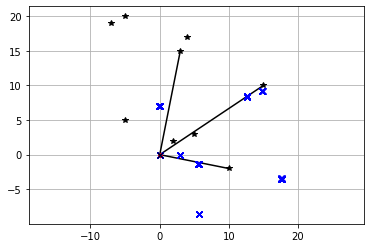

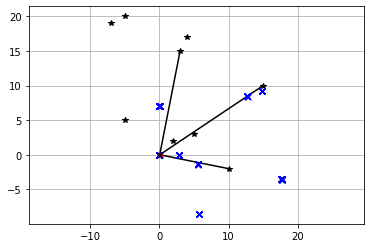

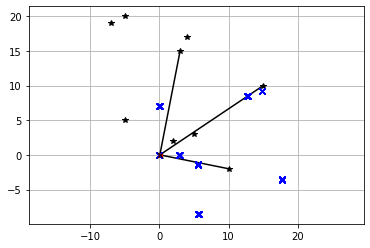

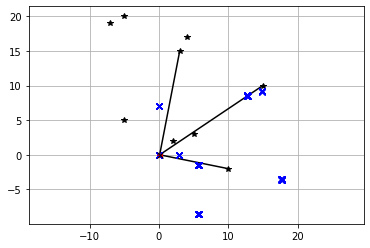

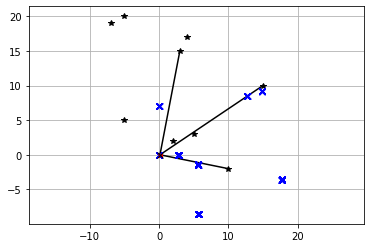

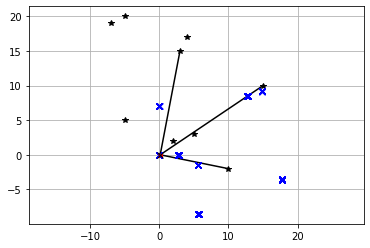

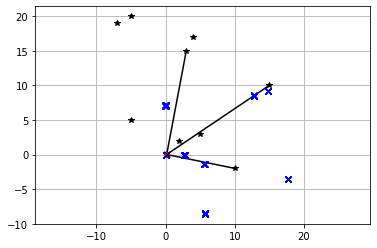

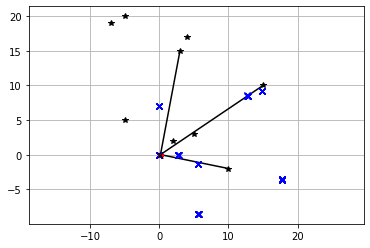

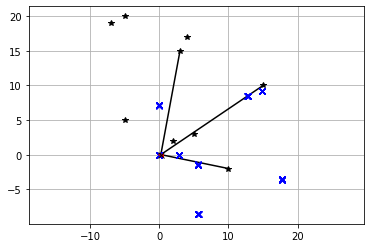

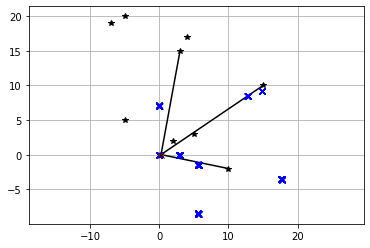

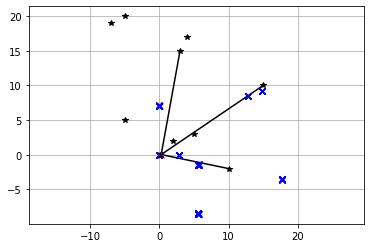

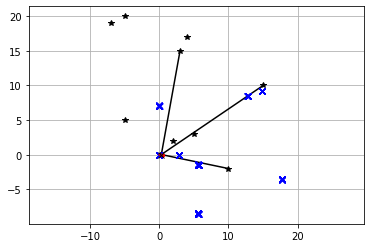

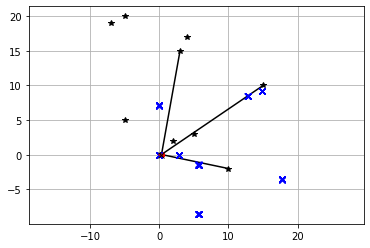

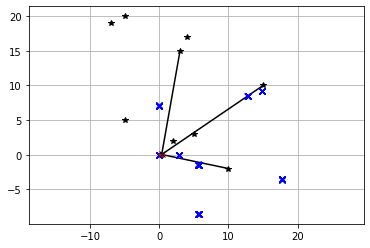

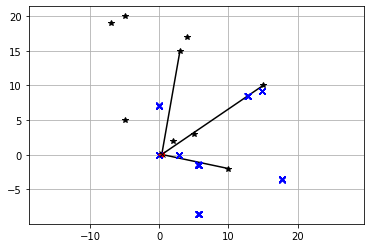

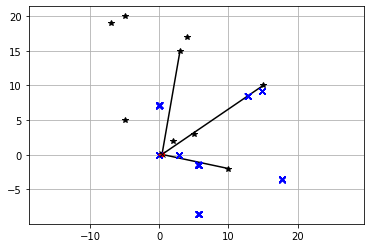

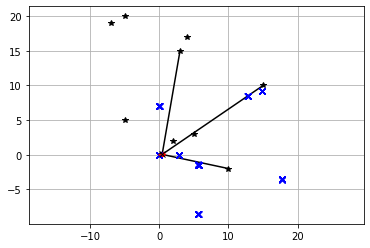

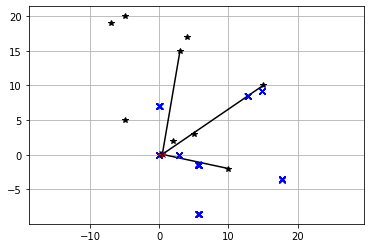

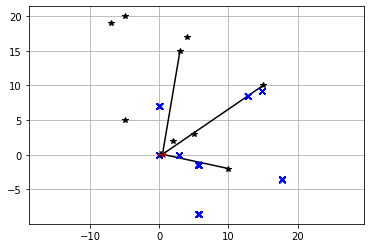

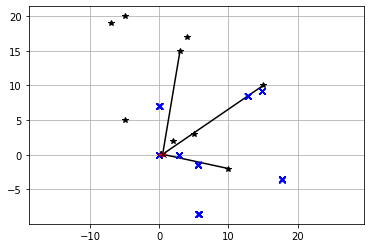

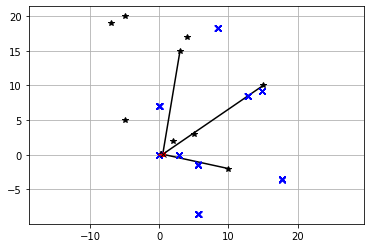

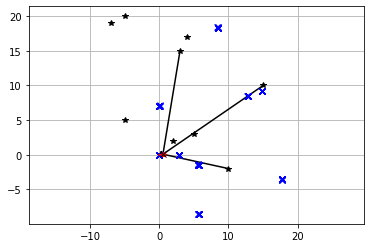

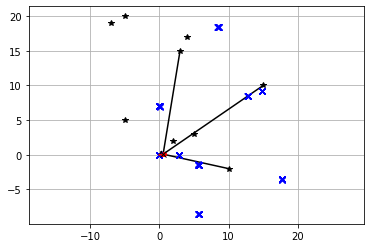

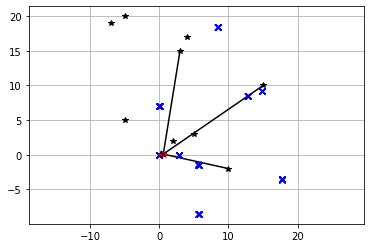

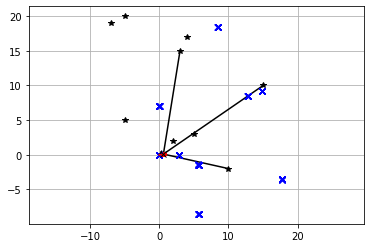

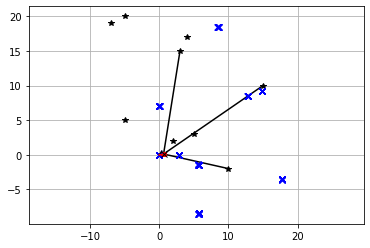

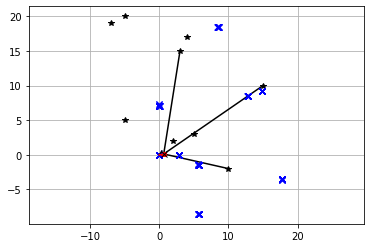

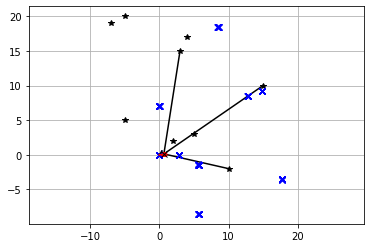

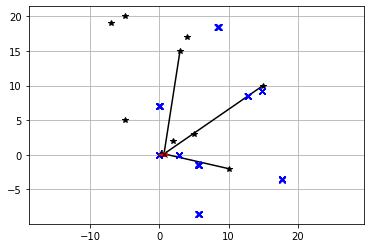

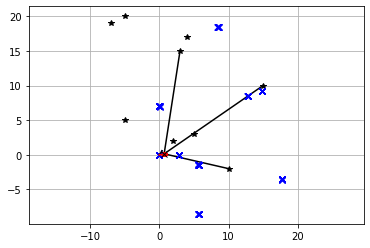

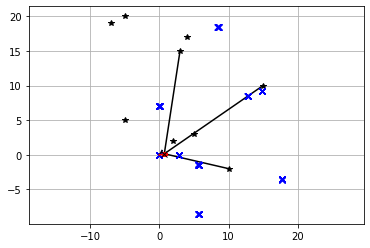

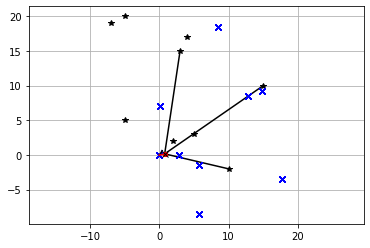

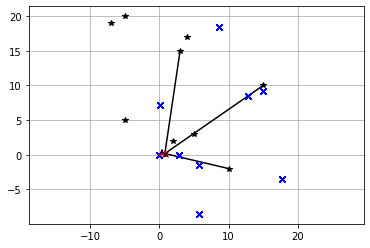

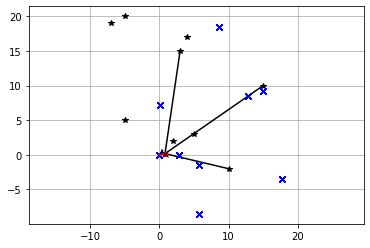

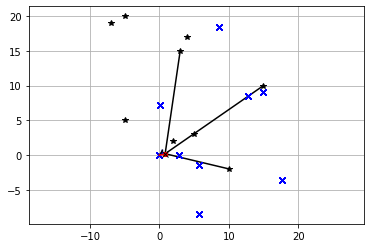

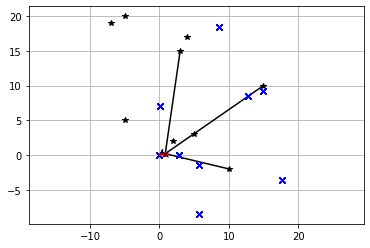

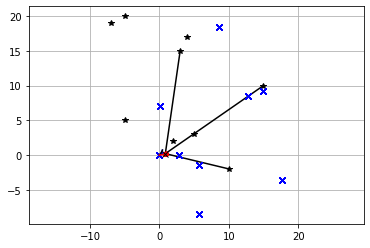

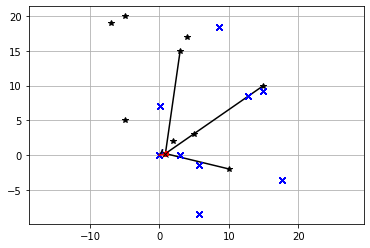

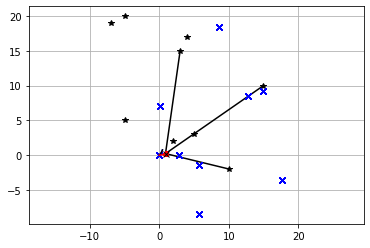

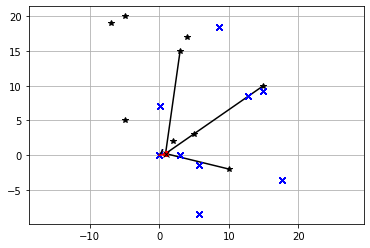

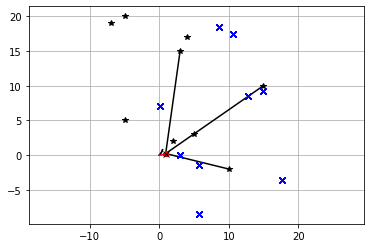

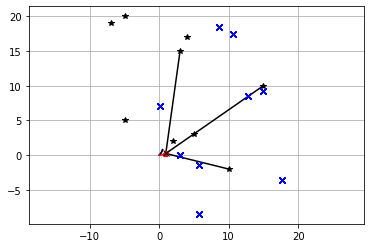

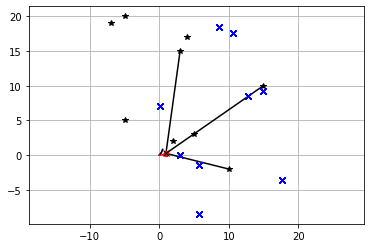

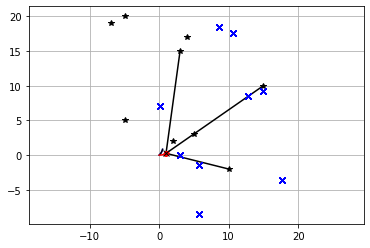

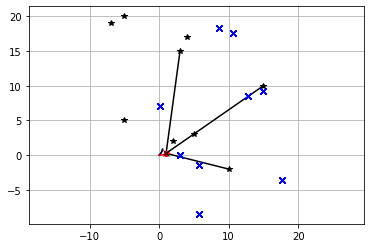

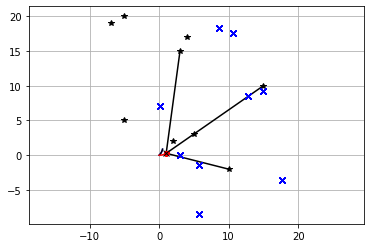

Time take to reach objective  (2.0, 2.0, 0.0)  was  0.46000000000000024  seconds


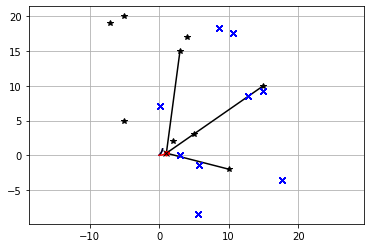

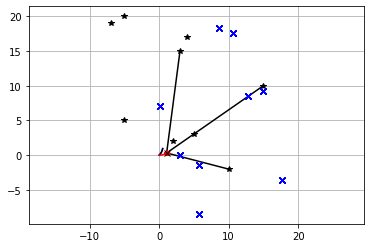

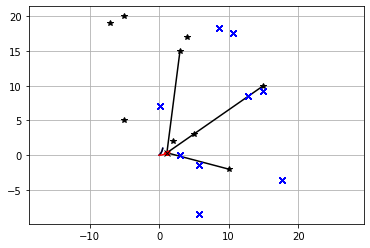

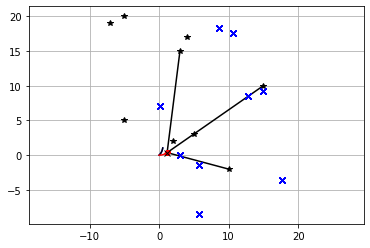

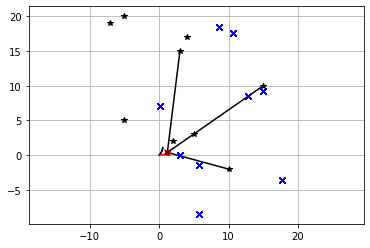

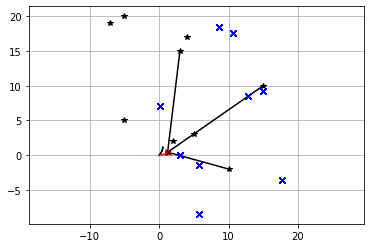

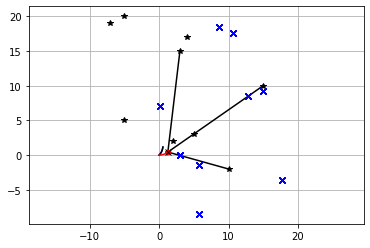

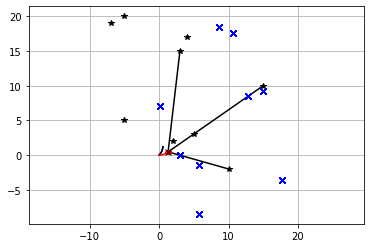

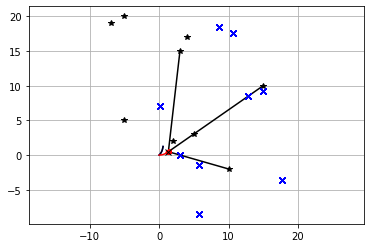

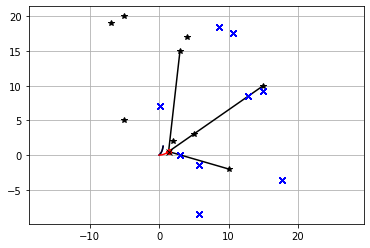

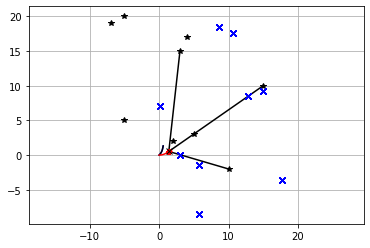

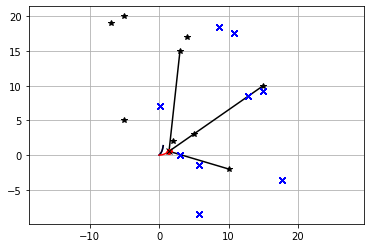

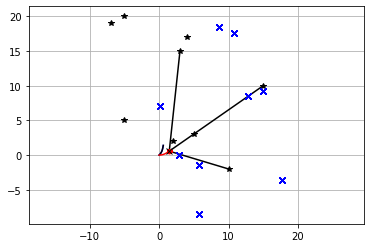

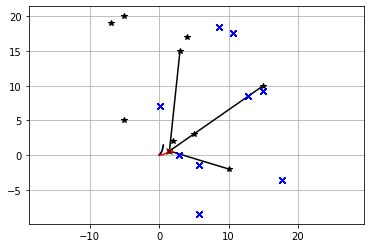

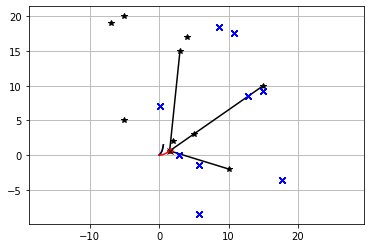

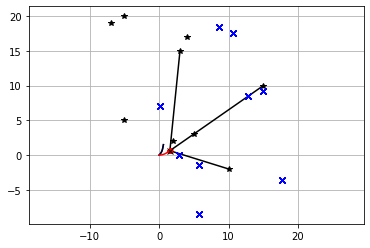

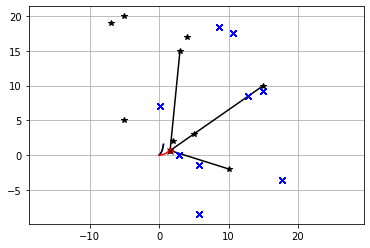

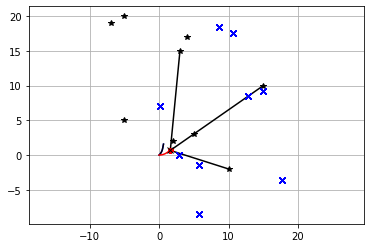

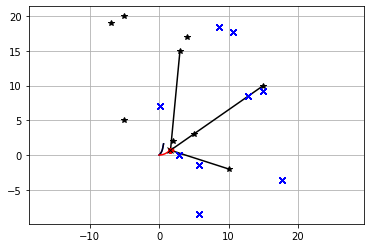

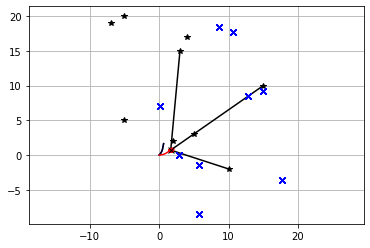

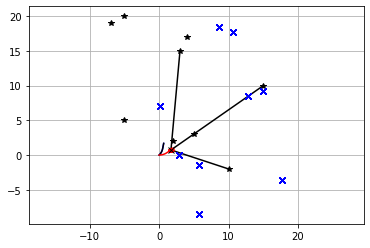

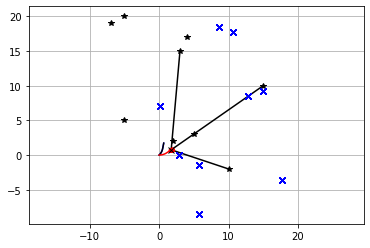

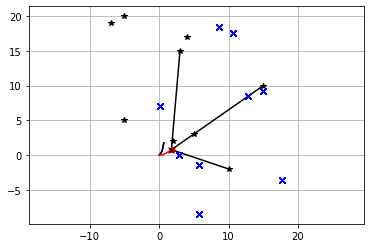

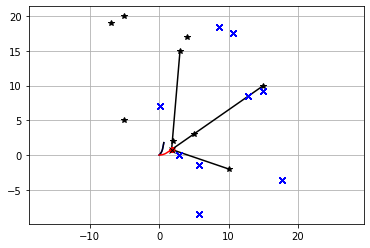

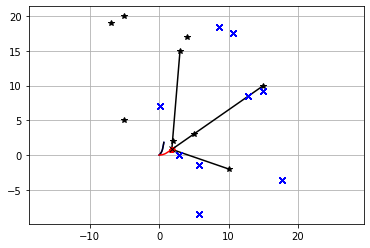

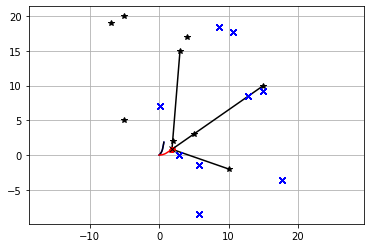

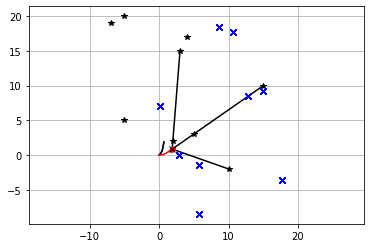

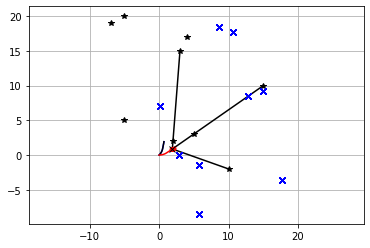

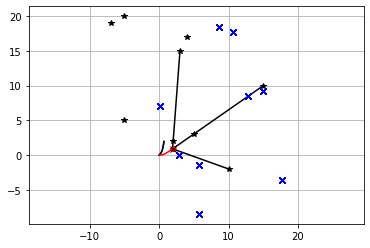

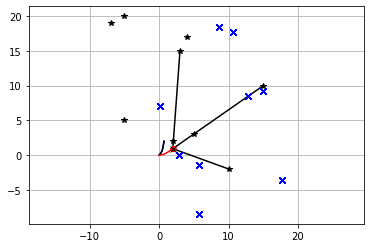

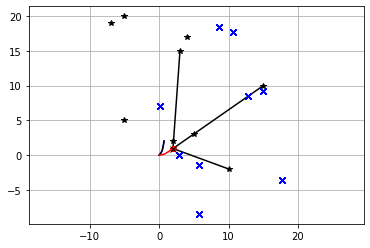

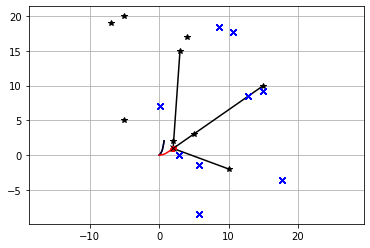

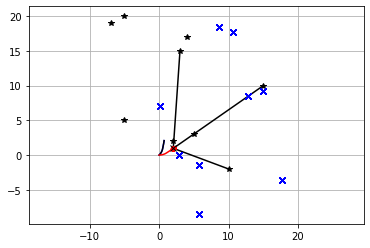

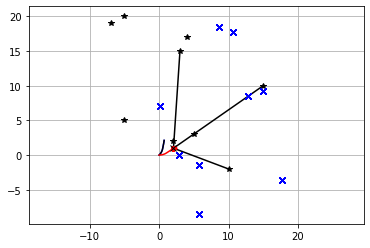

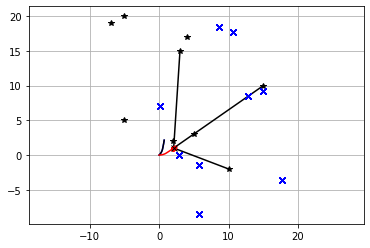

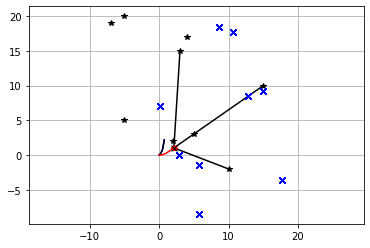

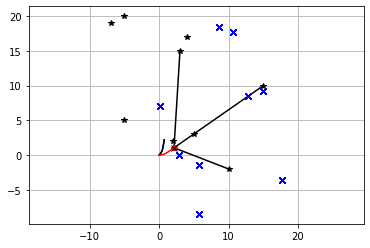

In [ ]:
show_animation = True
rov = Rover(0.0,0.0,0.0) # start it at the origin. 

waypoint_range = 2.0
# Waypoint landmarks [x, y, yaw]
waypoint_loc = np.array([[2.0, 2.0, 0.0],
                        [5.0, 3.0, 0.0],
                        [-7.0, 19.0, 0.0],
                        [4.0, 17.0, 0.0]])

# load target waypoints 
pose_goal = []
for waypoint in waypoint_loc:
    pose_goal.append(Pose(waypoint[0], waypoint[1], waypoint[2]))

rov.load_waypoints(pose_goal)
rov.set_target_range(waypoint_range)

sensor_range = 5.0

# consider 5 obstacles/landmarks 
# RFID positions [x, y, yaw]
RFID = np.array([[10.0, -2.0, 0.0],
                [15.0, 10.0, 0.0],
                [3.0, 15.0, 0.0],
                [-5.0, 20.0, 0.0],
                [-5.0, 5.0, 0.0]])

RFID = np.concatenate((RFID, waypoint_loc), axis=0)
N_LM = RFID.shape[0]

# State Vector [x y yaw v]'
xEst = np.zeros((fast_slam.STATE_SIZE, 1))  # SLAM estimation
xTrue = np.zeros((fast_slam.STATE_SIZE, 1))
xDR = np.zeros((fast_slam.STATE_SIZE, 1))  # Dead reckoning

xTrue[2] = np.deg2rad(45)
xDR[2] = np.deg2rad(45)

# history initial values
hxEst = xEst
hxTrue = xTrue
hxDR = xTrue

## Setting up simulation.
T = 0.0

pose_control.dt = fast_slam.DT = 0.01

particles = [Particle(N_LM) for i in range(fast_slam.N_PARTICLE)]

while not rov.path_complete():
    v = 10
    yaw_rate = 10
    while not rov.goal_reached():
        T += fast_slam.DT
        
        v, yaw_rate = pose_control.move_to_pose_step(rov, rov.target())
        
        if abs(v)>10:
            v = math.copysign(10, v)
        if abs(yaw_rate)>100:
            v = math.copysign(100, yawrate)
            
        u = np.array([[v, yaw_rate]]).T
        
        #todo(naverill) only add landmarks that the rover comes within 
        # sensor range 
        xTrue, z, xDR, ud = fast_slam.observation(xTrue, xDR, u, RFID)

        particles = fast_slam.fast_slam(particles, ud, z)

        xEst = fast_slam.calc_final_state(particles)

        x_state = xEst[0: fast_slam.STATE_SIZE]
        
        rov.x = xEst[0][0]
        rov.y = xEst[1][0]
        rov.theta = xEst[2][0]

        # store data history
        hxEst = np.hstack((hxEst, x_state))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))
        
        if show_animation:
            plt.cla()
            plt.plot(RFID[:, 0], RFID[:, 1], "*k")

            for iz in range(len(z[:, 0])):
                lmid = int(z[2, iz])
                plt.plot([xEst[0], RFID[lmid, 0]], [
                         xEst[1], RFID[lmid, 1]], "-k")

            for i in range(fast_slam.N_PARTICLE):
                plt.plot(particles[i].x, particles[i].y, ".r")
                plt.plot(particles[i].lm[:, 0], particles[i].lm[:, 1], "xb")

            plt.plot(hxTrue[0, :], hxTrue[1, :], "-b")
            plt.plot(hxDR[0, :], hxDR[1, :], "-k")
            plt.plot(hxEst[0, :], hxEst[1, :], "-r")
            plt.plot(xEst[0], xEst[1], "xk")
            plt.axis("equal")
            plt.grid(True)
            plt.pause(0.001)
    print("Time take to reach objective " , rov.target().get_pose()," was ", T, " seconds")
    rov.update_waypoints()


In [17]:
# x,y,_ = RFID.T
# plt.scatter(x, y, c='g')
# post_x, post_y, _ = waypoint_loc.T
# plt.scatter(post_x, post_y, c='purple')
# plt.plot(hxTrue[0, :],
#         hxTrue[1, :], "-b")
# plt.plot(hxDR[0, :],
#         hxDR[1, :], "-k")
# plt.plot(hxEst[0, :],
#         hxEst[1, :], "-r")
# plt.axis("equal")
# plt.grid(True)
# plt.pause(0.001)
# plt.show()

def plot_particles(t=0):
    x = []
    y = []
    for i in range(len(history[t])):
        x.append(history[t][i].x)
        y.append(history[t][i].y)
    plt.figtext(0.15,0.82,'t = ' + str(t))
    plt.plot(x, y, '.r')
    
    plt.plot(x, y, '.r')
    plt.axis([-20,20, -5,25])

interact(plot_particles, t=(0,len(history)-1,1));



NameError: name 'history' is not defined